In [4]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt

In [32]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("No GPUs available.")

num_skipped = 0
directory = "archive (2)"
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(directory,"PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

GPUs available:
 - /physical_device:GPU:0
Deleted 0 images.


In [33]:
image_size = (180, 180)
batch_size = 16

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "archive (2)/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


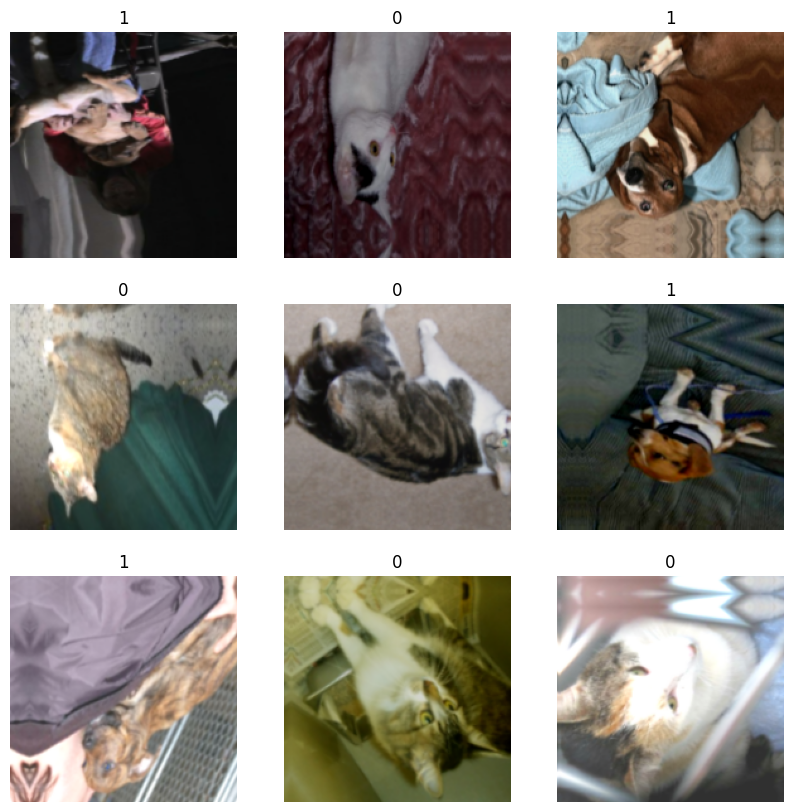

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [42]:
print(images.shape)
print(images.dtype)


(16, 180, 180, 3)
<dtype: 'float32'>


In [43]:
# import tensorflow as tf
# from tensorflow.keras import layers

# class RandomVerticalFlip(layers.Layer):
#     def __init__(self, probability=0.2, **kwargs):
#         super(RandomVerticalFlip, self).__init__(**kwargs)
#         self.probability = probability

#     def call(self, images, training=False):
#         if training:
#             return tf.cond(
#                 tf.random.uniform([]) < self.probability,
#                 lambda: tf.image.flip_up_down(images),
#                 lambda: images
#             )
#         return images

# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),  # Horizontal flips
#     RandomVerticalFlip(probability=0.2),  # Vertical flips with 20% probability
#     layers.RandomRotation(0.1),  # Random rotations by up to 10%
#     layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zooming
#     layers.RandomContrast(factor=0.2),  # Adjust contrast by a random factor
#     layers.RandomBrightness(factor=0.2),  # Adjust brightness by a random factor

#     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translations
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images, training=True)
#     return images

# import tensorflow as tf
# from tensorflow.keras import layers

# class RandomVerticalFlip(layers.Layer):
#     def __init__(self, probability=0.2, **kwargs):
#         super(RandomVerticalFlip, self).__init__(**kwargs)
#         self.probability = probability

#     def call(self, images, training=False):
#         if training:
#             return tf.cond(
#                 tf.random.uniform([]) < self.probability,
#                 lambda: tf.image.flip_up_down(images),
#                 lambda: images
#             )
#         return images

# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),  # Horizontal flips
#     RandomVerticalFlip(probability=0.2),  # Vertical flips with 20% probability
#     layers.RandomRotation(
#         factor=0.1,  # Random rotations up to 10 degrees
#         fill_mode="reflect",
#         interpolation="bilinear"
#     ),
#     layers.RandomZoom(
#         height_factor=0.2,
#         width_factor=0.2,  # Set width_factor to a specific value
#         fill_mode="reflect",
#         interpolation="bilinear"
#     ),  # Random zooming
#     layers.RandomContrast(factor=0.2),  # Adjust contrast by a random factor
#     layers.RandomBrightness(factor=0.2),  # Adjust brightness by a random factor
#     layers.RandomTranslation(
#         height_factor=0.1,
#         width_factor=0.1,
#         fill_mode="reflect",
#         interpolation="bilinear"
#     )  # Random translations
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images, training=True)
#     return images

import tensorflow as tf
from tensorflow.keras import layers

class RandomVerticalFlip(layers.Layer):
    def __init__(self, probability=0.2, **kwargs):
        super(RandomVerticalFlip, self).__init__(**kwargs)
        self.probability = probability

    def call(self, images, training=False):
        if training:
            return tf.cond(
                tf.random.uniform([]) < self.probability,
                lambda: tf.image.flip_up_down(images),
                lambda: images
            )
        return images

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    RandomVerticalFlip(probability=0.2),
    layers.RandomRotation(factor=0.2),  # Increased rotation factor
    layers.RandomZoom(height_factor=0.3, width_factor=0.3),  # Increased zoom factors
    layers.RandomContrast(factor=0.3),  # Increased contrast factor
    layers.RandomBrightness(factor=0.3),  # Increased brightness factor
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)  # Increased translation factors
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images, training=True)
    return images



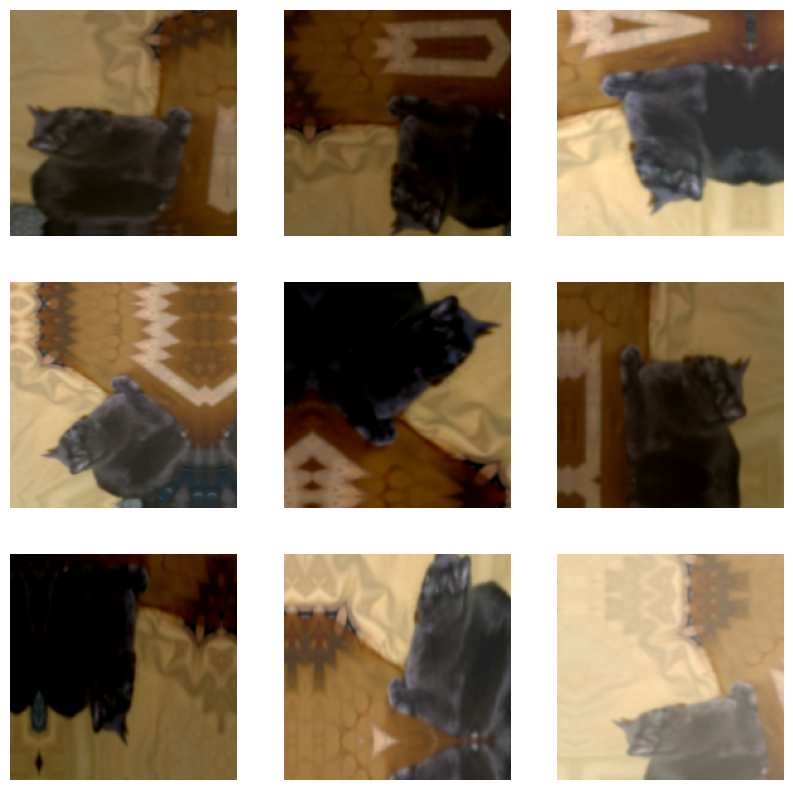

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [45]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


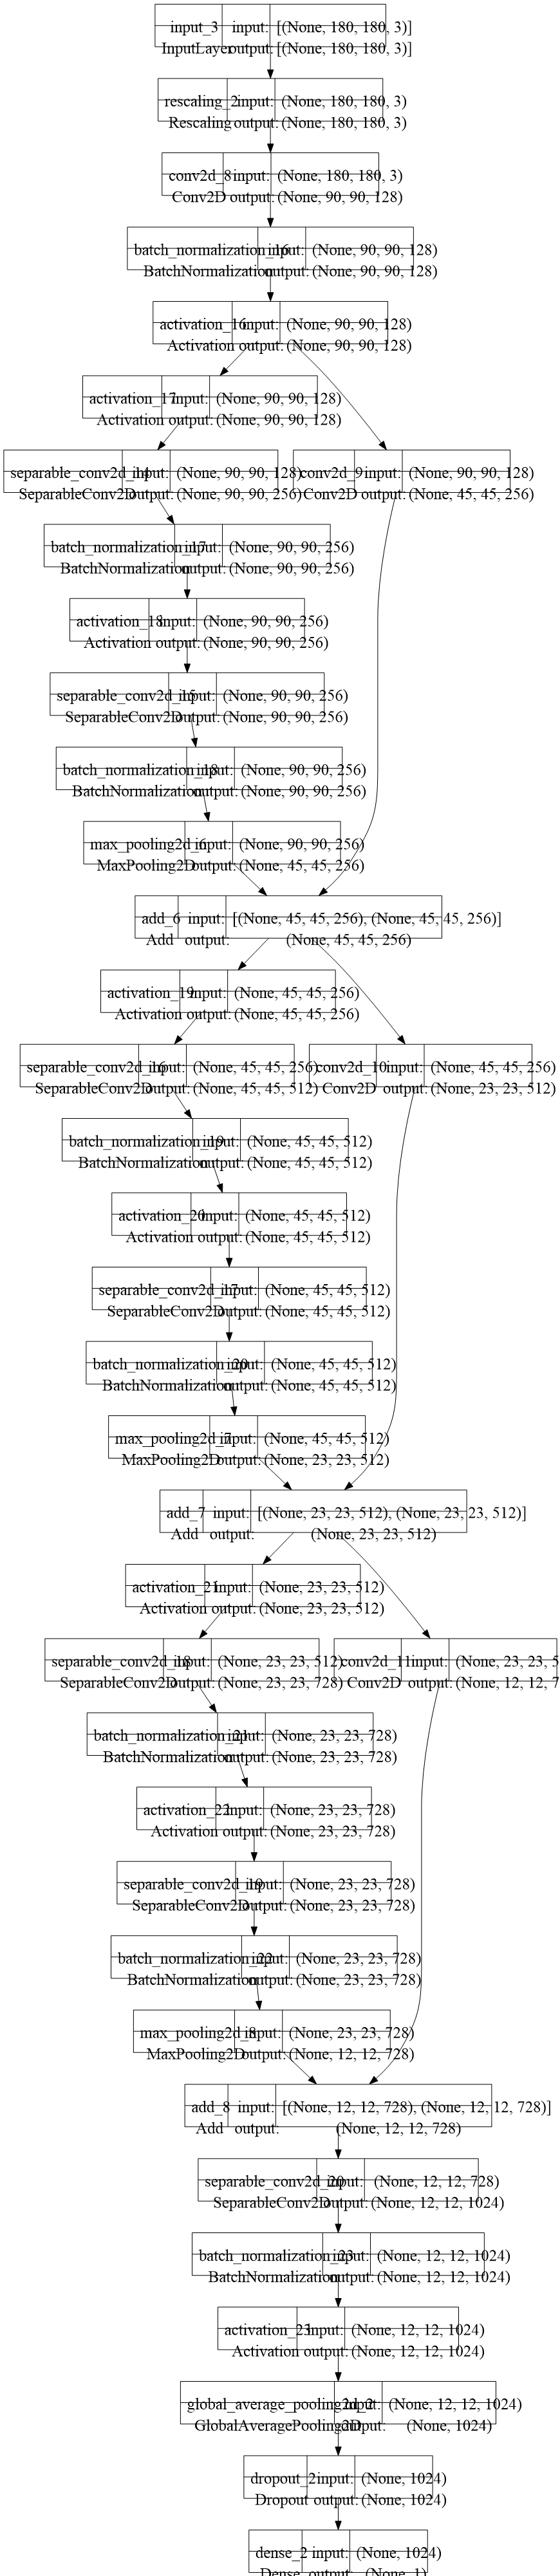

In [46]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [47]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
1172/1172 [==============================] - 407s 346ms/step - loss: 0.6866 - acc: 0.5652 - val_loss: 0.8327 - val_acc: 0.5282
Epoch 2/25
1172/1172 [==============================] - 398s 334ms/step - loss: 0.6487 - acc: 0.6035 - val_loss: 0.6547 - val_acc: 0.5647
Epoch 3/25
1172/1172 [==============================] - 314s 267ms/step - loss: 0.6304 - acc: 0.6209 - val_loss: 0.6423 - val_acc: 0.6939
Epoch 4/25
1172/1172 [==============================] - 461s 389ms/step - loss: 0.6036 - acc: 0.6520 - val_loss: 0.5380 - val_acc: 0.7675
Epoch 5/25
1172/1172 [==============================] - 446s 374ms/step - loss: 0.5789 - acc: 0.6769 - val_loss: 0.6497 - val_acc: 0.6793
Epoch 6/25
1172/1172 [==============================] - 443s 372ms/step - loss: 0.5534 - acc: 0.7020 - val_loss: 0.4981 - val_acc: 0.7442
Epoch 7/25
1143/1172 [============================>.] - ETA: 10s - loss: 0.5098 - acc: 0.7309

KeyboardInterrupt: 

In [44]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the number of additional epochs
additional_epochs = 35 - 25  # Adjust this if necessary

# Load the previously saved model
model = load_model("save_at_25.keras")  # Replace with your actual model file path

# Define the callbacks again
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras", save_best_only=True),
]

# Compile the model (use the same configuration as before)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

# Continue training
history = model.fit(
    train_ds,
    epochs=35,  # Total epochs you want to train
    initial_epoch=25,  # Start from the epoch after the last completed epoch
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 26/35
586/586 [==============================] - 168s 281ms/step - loss: 0.1507 - acc: 0.9355 - val_loss: 0.1645 - val_acc: 0.9451
Epoch 27/35
586/586 [==============================] - 187s 317ms/step - loss: 0.1413 - acc: 0.9388 - val_loss: 0.1216 - val_acc: 0.9475
Epoch 28/35
586/586 [==============================] - 198s 336ms/step - loss: 0.1392 - acc: 0.9414 - val_loss: 0.2022 - val_acc: 0.9283
Epoch 29/35
586/586 [==============================] - 203s 344ms/step - loss: 0.1402 - acc: 0.9391 - val_loss: 0.1897 - val_acc: 0.9419
Epoch 30/35
586/586 [==============================] - 215s 364ms/step - loss: 0.1355 - acc: 0.9430 - val_loss: 0.1169 - val_acc: 0.9575
Epoch 31/35
586/586 [==============================] - 213s 360ms/step - loss: 0.1267 - acc: 0.9463 - val_loss: 0.2541 - val_acc: 0.9253
Epoch 32/35
586/586 [==============================] - 214s 364ms/step - loss: 0.1204 - acc: 0.9477 - val_loss: 0.1316 - val_acc: 0.9490
Epoch 33/35
586/586 [====================

In [45]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the number of additional epochs
additional_epochs = 45 - 30

# Load the previously saved model
model = load_model("save_at_30.keras")

# Define the callbacks again
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras", save_best_only=True),
]

# Compile the model (use the same configuration as before)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

# Continue training
history = model.fit(
    train_ds,
    epochs=40,  # Total epochs from the start
    initial_epoch=30,  # Start from epoch 26
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 31/40
586/586 [==============================] - 214s 360ms/step - loss: 0.1335 - acc: 0.9445 - val_loss: 0.1353 - val_acc: 0.9530
Epoch 32/40
586/586 [==============================] - 224s 379ms/step - loss: 0.1301 - acc: 0.9457 - val_loss: 0.1701 - val_acc: 0.9202
Epoch 33/40
586/586 [==============================] - 223s 378ms/step - loss: 0.1307 - acc: 0.9441 - val_loss: 0.1358 - val_acc: 0.9488
Epoch 34/40
586/586 [==============================] - 233s 394ms/step - loss: 0.1224 - acc: 0.9481 - val_loss: 0.1399 - val_acc: 0.9526
Epoch 35/40
586/586 [==============================] - 234s 396ms/step - loss: 0.1246 - acc: 0.9473 - val_loss: 0.1344 - val_acc: 0.9564
Epoch 36/40
586/586 [==============================] - 237s 401ms/step - loss: 0.1166 - acc: 0.9514 - val_loss: 0.1176 - val_acc: 0.9588
Epoch 37/40
586/586 [==============================] - 231s 392ms/step - loss: 0.1165 - acc: 0.9491 - val_loss: 0.1321 - val_acc: 0.9419
Epoch 38/40
586/586 [====================

In [46]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the number of additional epochs
additional_epochs = 45 - 36

# Load the previously saved model
model = load_model("save_at_36.keras")

# Define the callbacks again
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras", save_best_only=True),
]

# Compile the model (use the same configuration as before)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

# Continue training
history = model.fit(
    train_ds,
    epochs=45,  # Total epochs from the start
    initial_epoch=36,  # Start from epoch 26
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 37/45
586/586 [==============================] - 210s 352ms/step - loss: 0.1174 - acc: 0.9498 - val_loss: 0.1256 - val_acc: 0.9477
Epoch 38/45
586/586 [==============================] - 235s 397ms/step - loss: 0.1200 - acc: 0.9490 - val_loss: 0.1280 - val_acc: 0.9415
Epoch 39/45
586/586 [==============================] - 243s 412ms/step - loss: 0.1127 - acc: 0.9529 - val_loss: 0.1337 - val_acc: 0.9558
Epoch 40/45
586/586 [==============================] - 251s 426ms/step - loss: 0.1083 - acc: 0.9550 - val_loss: 0.1204 - val_acc: 0.9571
Epoch 41/45
586/586 [==============================] - 255s 431ms/step - loss: 0.1030 - acc: 0.9568 - val_loss: 0.1373 - val_acc: 0.9415
Epoch 42/45
586/586 [==============================] - 258s 436ms/step - loss: 0.0992 - acc: 0.9587 - val_loss: 0.1125 - val_acc: 0.9582
Epoch 43/45
586/586 [==============================] - 237s 402ms/step - loss: 0.1064 - acc: 0.9554 - val_loss: 0.1412 - val_acc: 0.9385
Epoch 44/45
586/586 [====================

In [47]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the number of additional epochs
additional_epochs = 50 - 42

# Load the previously saved model
model = load_model("save_at_42.keras")

# Define the callbacks again
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras", save_best_only=True),
]

# Compile the model (use the same configuration as before)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

# Continue training
history = model.fit(
    train_ds,
    epochs=50,  # Total epochs from the start
    initial_epoch=42,  # Start from epoch 26
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 43/50
586/586 [==============================] - 219s 365ms/step - loss: 0.1050 - acc: 0.9560 - val_loss: 0.2858 - val_acc: 0.9199
Epoch 44/50
586/586 [==============================] - 233s 395ms/step - loss: 0.1044 - acc: 0.9565 - val_loss: 0.1204 - val_acc: 0.9539
Epoch 45/50
586/586 [==============================] - 234s 396ms/step - loss: 0.0982 - acc: 0.9600 - val_loss: 0.1316 - val_acc: 0.9372
Epoch 46/50
586/586 [==============================] - 235s 398ms/step - loss: 0.0974 - acc: 0.9586 - val_loss: 0.1357 - val_acc: 0.9443
Epoch 47/50
586/586 [==============================] - 236s 400ms/step - loss: 0.0957 - acc: 0.9605 - val_loss: 0.2174 - val_acc: 0.9129
Epoch 48/50
586/586 [==============================] - 236s 400ms/step - loss: 0.0883 - acc: 0.9637 - val_loss: 0.3366 - val_acc: 0.9112
Epoch 49/50
586/586 [==============================] - 237s 402ms/step - loss: 0.0928 - acc: 0.9626 - val_loss: 0.1788 - val_acc: 0.8973
Epoch 50/50
586/586 [====================

In [9]:
import tensorflow as tf
# Evaluate the model on the validation set
model = tf.keras.models.load_model("save_at_29.keras")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Itrain
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Train Loss: {train_ds}")
print(f"Train Accuracy: {train_ds}")


147/147 [==============================] - 16s 109ms/step - loss: 0.1216 - acc: 0.9509
Validation Loss: 0.12160184979438782
Validation Accuracy: 0.950896680355072
586/586 [==============================] - 57s 97ms/step - loss: 0.1110 - acc: 0.9557
Train Loss: <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Train Accuracy: <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


147/147 [==============================] - 11s 72ms/step
Precision: 0.9552
Recall: 0.9471


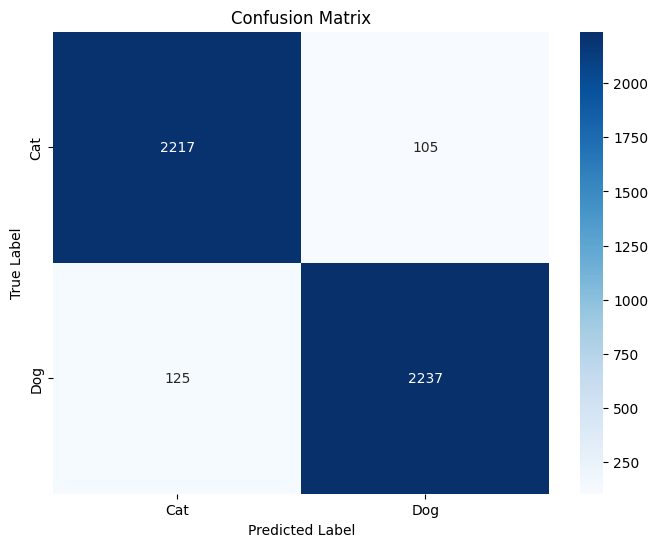

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("save_at_29.keras")

# Generate predictions on validation dataset
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Calculate Precision & Recall
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


147/147 [==============================] - 9s 56ms/step


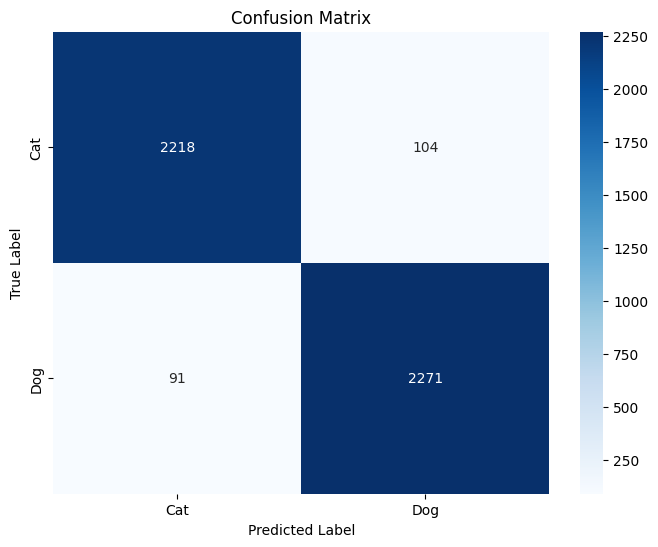

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = tf.keras.models.load_model("save_at_36.keras")
# Assuming you have a validation dataset named `val_ds`
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


147/147 [==============================] - 8s 55ms/step
Precision: 0.9562
Recall: 0.9615


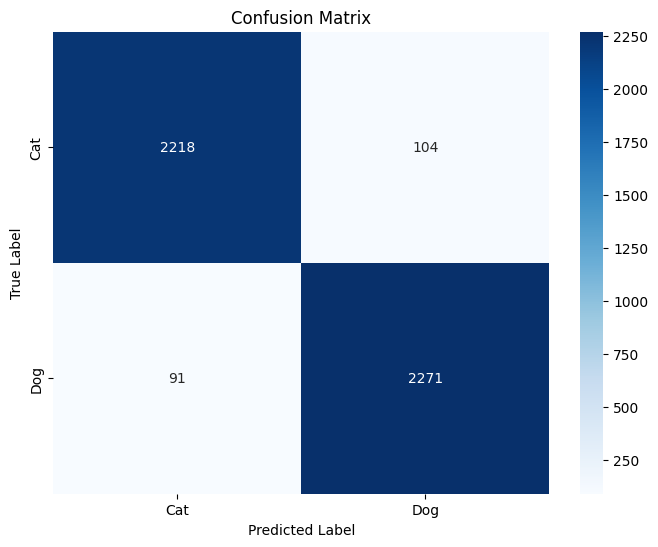

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("save_at_36.keras")

# Generate predictions on validation dataset
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Calculate Precision & Recall
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Load the model
model = tf.keras.models.load_model("C:\\Vertical flip\\save_at_36.keras")

# Assuming test_ds is your test dataset
test_images, test_labels = [], []
image_names = []

for images, labels in val_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
    # Assuming images are in a directory with filenames
    # image_names.append(image filenames)
    # Replace with the actual code to get filenames

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(test_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Convert predictions to scores (probabilities)
scores = predictions.flatten()

# Dummy image names if not available
image_names = [f"image_{i}.jpg" for i in range(len(test_images))]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    "image_name": image_names,
    "true_prediction": test_labels,
    "model_prediction": predicted_labels.flatten(),
    "score": scores
})

# Save to CSV
results_df.to_csv("test_results2.csv", index=False)

print("CSV file created successfully.")


147/147 [==============================] - 8s 55ms/step
CSV file created successfully.


In [ ]:
image_size = (180, 180)//  # Set your target image size
# img = keras.utils.load_img("archive (2)/PetImages/Dog/6779.jpg", target_size=image_size)
img = keras.utils.load_img("C:\\python2024\\Cat vs Dog\\images (4).jpg", target_size=image_size)
# img = keras.utils.load_img("C:archive (2)\\PetImages\\Dog\\4.jpg", target_size=image_size)
# "C:\python2024\Cat vs Dog\archive (2)\PetImages\Dog\4.jpg"
plt.imshow(img)

# Convert the image to an array
img_array = keras.utils.img_to_array(img)

# Expand dimensions to create a batch axis
img_array = np.expand_dims(img_array, axis=0)  # or use tf.expand_dims(img_array, axis=0)

# Make predictions using the model
predictions = model.predict(img_array)

# Apply sigmoid to the predictions to get the probabilities
score = float(tf.keras.activations.sigmoid(predictions[0][0]))

# Print the result
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


SyntaxError: invalid syntax (4176029120.py, line 1)

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy from the history
acc = history.history['acc']
val_acc = history.history['val_acc']

# Extract loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs
epochs_range = range(epochs)

# Plotting Accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


NameError: name 'history' is not defined